In [19]:
"""Environmental Setup
Importing required libraries into python for EDA."""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [20]:
#Connecting MySQL to Python.
conn = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = "AUXHIDEtpro2409@#",
    database = "sales_analytics"
)

query = "SELECT * FROM orders"
df = pd.read_sql(query,conn)

C:\Users\Lohit\AppData\Local\Temp\ipykernel_15160\3945467709.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,conn)


In [21]:
#Total no. of rows and coloumns.
df.shape


(50000, 13)

In [22]:
#First 5 values in the dataset.
df.head()

,order_id,order_date,customer_id,product_id,region,quantity,unit_price,discount_pct,revenue,discount_amount,net_revenue,cost,profit
0,1,2022-04-13,1808,235,West,6,1158.0,15.0,6948.0,1042.20,5905.80,4250.88,1654.92
1,2,2023-03-12,3151,383,East,6,2554.0,20.0,15324.0,3064.80,12259.20,8490.26,3768.94
2,3,2024-05-10,4293,366,West,7,2966.0,0.0,20762.0,0.00,20762.00,13387.10,7374.90
3,4,2022-09-28,2305,340,West,9,4775.0,5.0,42975.0,2148.75,40826.25,32277.07,8549.18
4,5,2022-04-17,4459,238,East,6,216.0,5.0,1296.0,64.80,1231.20,940.96,290.24


In [23]:
#Date type information of the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         50000 non-null  int64  
 1   order_date       50000 non-null  object 
 2   customer_id      50000 non-null  int64  
 3   product_id       50000 non-null  int64  
 4   region           50000 non-null  object 
 5   quantity         50000 non-null  int64  
 6   unit_price       50000 non-null  float64
 7   discount_pct     50000 non-null  float64
 8   revenue          50000 non-null  float64
 9   discount_amount  50000 non-null  float64
 10  net_revenue      50000 non-null  float64
 11  cost             50000 non-null  float64
 12  profit           50000 non-null  float64
dtypes: float64(7), int64(4), object(2)
memory usage: 5.0+ MB


In [24]:
#Checking for null values.
df.isna().sum()

order_id           0
order_date         0
customer_id        0
product_id         0
region             0
quantity           0
unit_price         0
discount_pct       0
revenue            0
discount_amount    0
net_revenue        0
cost               0
profit             0
dtype: int64

In [25]:
df["order_date"] = pd.to_datetime(df["order_date"])

In [26]:
#Checking for duplicates.
df.duplicated().sum()

np.int64(0)

In [27]:
#Feature engineering.
df["order_month"] = df["order_date"].dt.to_period("M").astype(str)
df["order_month"] = df["order_date"].dt.to_period("Q").astype(str)
df["profit_margin_pct"] = (df["profit"]/df["net_revenue"])*100

print("Feature engineering executed")

Feature engineering executed


In [30]:
df["price_bucket"] = pd.cut(
    df["unit_price"], 
    bins = [0,500,1000, 3000,5000],
    labels = ["Low", "Mid", "High", "Premium"]
)

print("price bucket feature executed")

price bucket feature executed


In [ ]:
#EXPLORATORY DATA ANALYSIS

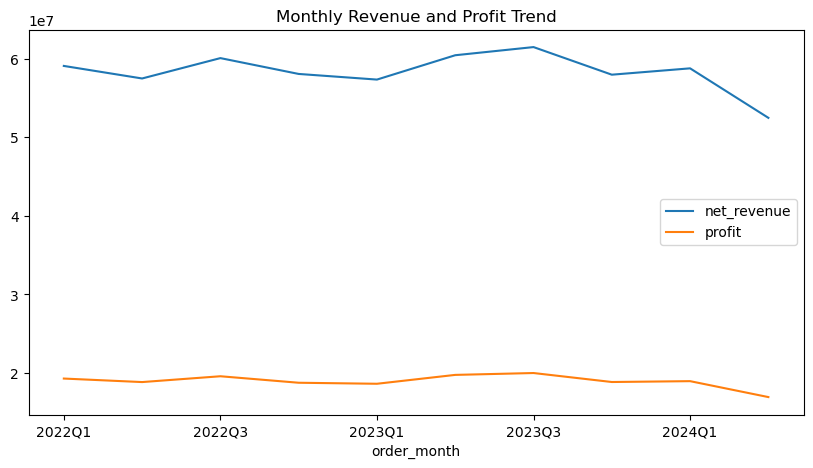

In [34]:
#Revenue and Profit Trend
monthly_trend = df.groupby("order_month")[["net_revenue","profit"]].sum()

monthly_trend.plot(figsize = (10,5))
plt.title("Monthly Revenue and Profit Trend")
plt.show()

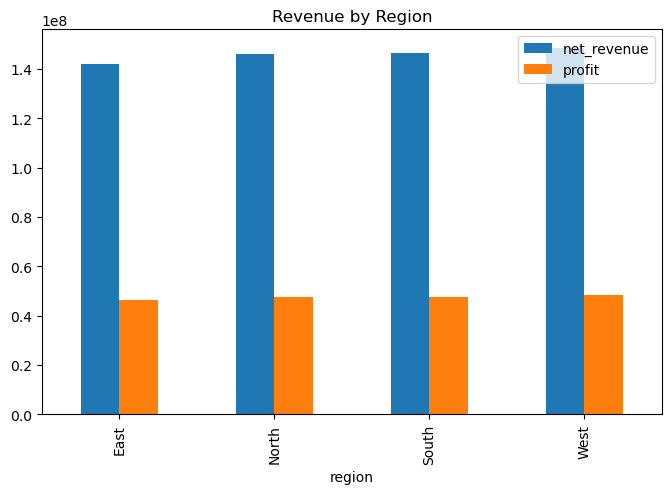

In [37]:
region_perf = df.groupby("region")[["net_revenue","profit"]].sum().sort_values("profit")

region_perf.plot(kind = "bar", figsize = (8,5))
plt.title("Revenue by Region")
plt.show()

In [38]:
#Discount Vs. Profitability
discount_analysis = df.groupby("discount_pct")[["net_revenue", "profit"]].sum()
discount_analysis

,net_revenue,profit
discount_pct,,
0.0,1.308565e+08,42464458.80
5.0,1.220269e+08,39594190.35
10.0,1.200208e+08,39064888.54
15.0,1.078852e+08,35089968.79
20.0,1.022208e+08,33421415.61


In [42]:
#Top and Bottom Products

product_profit = df.groupby("product_id")["profit"].sum()

top_products = product_profit.sort_values(ascending = False).head(10)
bottom_products = product_profit.sort_values(ascending = True).head(10)

In [43]:
top_products 

product_id
388    1195481.68
222    1140898.35
302    1140458.81
290    1135338.82
342    1131956.74
314    1131761.11
300    1125162.37
372    1113712.51
385    1109390.26
339    1100484.29
Name: profit, dtype: float64

In [44]:
bottom_products

product_id
223    710560.27
253    713508.36
384    720584.07
397    726745.27
337    776716.97
266    779623.27
381    797630.10
364    798520.19
263    801069.57
288    803172.60
Name: profit, dtype: float64

In [48]:
#Aggeregation for BI tools

monthly_summary = df.groupby(
    ["order_date", "region"])[["net_revenue", "profit"]].sum().reset_index()

product_summary = df.groupby("product_id").agg(
    total_revenue = ("net_revenue" ,"sum"),
    total_profit = ("profit", "sum"),
    avg_margin = ("profit_margin_pct", "mean")
).reset_index()

customer_summary = df.groupby("customer_id").agg(
    total_revenue = ("net_revenue", "sum"),
    total_orders = ("order_id", "sum"),
    total_profit = ("profit", "sum")
).reset_index()

In [52]:
#Exporting to PowerBI
df.to_csv(r"C:/Users/Lohit/Desktop/Data Analyst Project/Python Files/.py files/clean_orders.csv", index = False)
monthly_summary.to_csv(r"C:/Users/Lohit/Desktop/Data Analyst Project/Python Files/.py files/monthly_summary.csv", index = False)
product_summary.to_csv(r"C:/Users/Lohit/Desktop/Data Analyst Project/Python Files/.py files/product_summary.csv", index = False)
customer_summary.to_csv(r"C:/Users/Lohit/Desktop/Data Analyst Project/Python Files/.py files/customer_summary.csv", index = False)

print("Export Complete")

Export Complete
